In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import json

import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.model_selection import GroupKFold
from typing import Any
from numba import jit
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from itertools import product
import copy
import time

import random
seed = 1234
random.seed(seed)
np.random.seed(seed)

import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as plt
import calendar
import warnings
warnings.filterwarnings("ignore")

# Any results you write to the current directory are saved as output.

/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


## This draft is uses all of the data available in the train set including Clips, Games and Activities along with Assessments for evaluating the accuracy of the last game_session of an installation_id in the test set.

## Regression is then used to obtain the accuracy for each of the desired assessments which are then converted to accuracy_labels.

In [2]:
%%time
train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
submit = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')

CPU times: user 1min 12s, sys: 8.47 s, total: 1min 21s
Wall time: 1min 21s


## In this 1st part I will divide the test dataset into 2 parts:
### 1. final_preds: Contains the final assessment for each installation id in the test set
### 2. test_preds: Contains all other assessments.

## I will predict the accuracy for each of the assessments in the test_preds based on num_incorrect and num_correct columns obtained from event_data.

In [3]:
def assessments(df):
    keep_id = df[df['type'] == 'Assessment'][['installation_id']].drop_duplicates()
    df = pd.merge(df, keep_id, on='installation_id', how='inner')
    df = df[df['type'] == 'Assessment']
    return df

test_asses = assessments(test)

In [4]:
def evdata(row):
    row['correct'] = 0
    row['incorrect'] = 0
    if json.loads(row['event_data'])['correct'] == True: row['correct'] = 1
    else: row['incorrect'] = 1
    return row

In [5]:
def featureEng(df):
    df_temp = df[((df.title == 'Bird Measurer (Assessment)') & (df.event_code == 4110)) |
                                               ((df.title != 'Bird Measurer (Assessment)') & (df.event_code == 4100))]
    df_temp2 = df[~(((df.title == 'Bird Measurer (Assessment)') & (df.event_code == 4110)) |
                                               ((df.title != 'Bird Measurer (Assessment)') & (df.event_code == 4100)))]
    
    df_temp1 = df_temp.apply(evdata, axis=1)
    
    rows = df_temp2.shape[0]
    temp3 = pd.DataFrame(columns=['correct', 'incorrect'], index=df_temp2.index, data=0)
    df_temp2 = pd.concat([df_temp2, temp3], axis=1)
    df_comb = pd.concat([df_temp2, df_temp1])
    
    return df_comb

In [6]:
new_test = featureEng(test_asses)

In [7]:
new_test.tail()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,correct,incorrect
1156280,392e14df,c116d9e6f8cf85c3,2019-09-10T18:55:19.532Z,"{""buckets"":[2,3,1],""correct"":false,""buckets_pl...",ffe00ca8,24,4100,13351,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,0,1
1156309,392e14df,c116d9e6f8cf85c3,2019-09-10T18:55:36.816Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",ffe00ca8,53,4100,30620,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1,0
1156329,392e14df,70336ec581799feb,2019-09-10T18:56:10.372Z,"{""buckets"":[3,2,1],""correct"":false,""buckets_pl...",ffe00ca8,5,4100,4701,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,0,1
1156352,392e14df,70336ec581799feb,2019-09-10T18:56:26.743Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",ffe00ca8,27,4100,21068,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1,0
1156406,25fa8af4,46ff9d3ad2be09f2,2019-09-28T21:20:36.714Z,"{""correct"":true,""stumps"":[2,3,4],""event_count""...",ffe774cc,36,4100,27797,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,1,0


In [8]:
def group_sess(df):
    df_sum = df.groupby('game_session').sum()
    df_max = df.groupby('game_session').max()
    
    df_sum.drop(['event_count', 'game_time'], axis=1, inplace=True)
    df_sum = df_sum.astype(int)
    
    fts = df_max.columns
    df_max.drop(fts.drop(['timestamp', 'installation_id', 'event_count', 'game_time', 'title', 'world']), axis=1, inplace=True)
    
    df_sess = pd.concat([df_max, df_sum], axis=1)
    df_sess.reset_index(inplace=True)
    return df_sess

In [9]:
test_sess = group_sess(new_test)

In [10]:
def time_stamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

#test_sess = time_stamp(test_sess)

In [11]:
test_sess.head()

,game_session,timestamp,installation_id,event_count,game_time,title,world,event_code,correct,incorrect
0,001a139acd7fce92,2019-09-28T20:32:07.056Z,285b65c8,130,181512,Bird Measurer (Assessment),TREETOPCITY,469542,1,15
1,003bafadf2259738,2019-10-12T02:28:25.426Z,56a739ec,74,168622,Bird Measurer (Assessment),TREETOPCITY,267577,1,0
2,006b058c3bba11a2,2019-08-29T19:43:20.698Z,d95dc7cb,35,33373,Mushroom Sorter (Assessment),TREETOPCITY,113703,1,0
3,007195dd54b7c251,2019-08-26T18:30:58.563Z,6cd8f2d8,27,34553,Cart Balancer (Assessment),CRYSTALCAVES,94942,1,0
4,007b28de31382377,2019-09-16T12:27:32.049Z,ce08e98b,47,32339,Mushroom Sorter (Assessment),TREETOPCITY,166391,0,1


In [12]:
ids = test_sess['installation_id'].unique()
cols = test_sess.columns
final_preds = pd.DataFrame(columns=cols)
test_preds = pd.DataFrame(columns=cols)

for i in ids:
    final_preds = final_preds.append(test_sess[(test_sess['installation_id'] == i) & (test_sess['timestamp'] == max(test_sess[test_sess['installation_id'] == i]['timestamp']))])
    test_preds = test_preds.append(test_sess[(test_sess['installation_id'] == i) & (test_sess['timestamp'] != max(test_sess[test_sess['installation_id'] == i]['timestamp']))])

> ### Here, I'm removing all those game_sessions which have no correct or incorrect answers

In [13]:
test_preds = test_preds[~((test_preds['incorrect'] == 0) & (test_preds['correct'] == 0))]

In [14]:
test_preds.head()

,game_session,timestamp,installation_id,event_count,game_time,title,world,event_code,correct,incorrect
0,001a139acd7fce92,2019-09-28T20:32:07.056Z,285b65c8,130,181512,Bird Measurer (Assessment),TREETOPCITY,469542,1,15
697,348a625a5eac8688,2019-09-28T20:19:48.301Z,285b65c8,45,54914,Mushroom Sorter (Assessment),TREETOPCITY,152433,1,1
1,003bafadf2259738,2019-10-12T02:28:25.426Z,56a739ec,74,168622,Bird Measurer (Assessment),TREETOPCITY,267577,1,0
164,0c438fc99f4da833,2019-07-27T23:16:19.773Z,56a739ec,37,50840,Cauldron Filler (Assessment),MAGMAPEAK,123631,1,0
269,1330af2eb576d74b,2019-07-31T23:08:31.976Z,56a739ec,35,39414,Mushroom Sorter (Assessment),TREETOPCITY,115653,1,0


In [15]:
def acc_pred(df):
    df['accuracy'] = df['correct']/(df['correct'] + df['incorrect'])
    return df
test_preds = acc_pred(test_preds)

In [16]:
test_preds.head()

,game_session,timestamp,installation_id,event_count,game_time,title,world,event_code,correct,incorrect,accuracy
0,001a139acd7fce92,2019-09-28T20:32:07.056Z,285b65c8,130,181512,Bird Measurer (Assessment),TREETOPCITY,469542,1,15,0.0625
697,348a625a5eac8688,2019-09-28T20:19:48.301Z,285b65c8,45,54914,Mushroom Sorter (Assessment),TREETOPCITY,152433,1,1,0.5
1,003bafadf2259738,2019-10-12T02:28:25.426Z,56a739ec,74,168622,Bird Measurer (Assessment),TREETOPCITY,267577,1,0,1
164,0c438fc99f4da833,2019-07-27T23:16:19.773Z,56a739ec,37,50840,Cauldron Filler (Assessment),MAGMAPEAK,123631,1,0,1
269,1330af2eb576d74b,2019-07-31T23:08:31.976Z,56a739ec,35,39414,Mushroom Sorter (Assessment),TREETOPCITY,115653,1,0,1


In [17]:
final_preds.drop(['event_code', 'correct', 'incorrect', 'game_time', 'event_count'], axis=1, inplace=True)

In [18]:
final_preds.head()  ## Ultimately, we need to predict the outcomes for this dataframe.

,game_session,timestamp,installation_id,title,world
2577,c3217a76d36ca418,2019-09-29T23:39:01.711Z,285b65c8,Cauldron Filler (Assessment),MAGMAPEAK
2928,de5eb179a197439a,2019-10-12T02:53:14.700Z,56a739ec,Cart Balancer (Assessment),CRYSTALCAVES
1717,81df2a785dbb95bb,2019-09-09T18:55:49.174Z,d95dc7cb,Mushroom Sorter (Assessment),TREETOPCITY
253,11f81045ca2c4766,2019-09-02T16:12:31.500Z,6cd8f2d8,Cauldron Filler (Assessment),MAGMAPEAK
672,32e1adeca07aff00,2019-09-19T12:55:30.891Z,ce08e98b,Cauldron Filler (Assessment),MAGMAPEAK


## I can now seperate out all the events leading upto this final game session for each installation id in the test set. This will give me the desired set of features in the form of Clips, games and activities as well.

In [19]:
test = time_stamp(test)

In [20]:
test = test[~(test['world'] == 'NONE')]

In [21]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10 16:51:51.805000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10 16:53:12.825000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10 16:54:12.115000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES
5,f93fc684,a022c3f60ba547e7,2019-09-10 16:54:14.338000+00:00,"{""coordinates"":{""x"":515,""y"":697,""stage_width"":...",00abaee7,2,4010,2232,Chow Time,Game,CRYSTALCAVES


In [22]:
new_test_sess = test.groupby('game_session').max()

In [23]:
new_test_sess.reset_index(inplace=True)

In [24]:
new_test_sess.head()

,game_session,event_id,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,000326e9d4516dd0,f54238ee,2019-10-02 20:03:58.224000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",48166507,301,4090,209785,Fireworks (Activity),Activity,TREETOPCITY
1,0003a9881ca100aa,fcfdffb6,2019-09-06 12:41:18.339000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",13a0754c,96,4070,152639,Flower Waterer (Activity),Activity,TREETOPCITY
2,00094643cae0f886,27253bdc,2019-10-05 23:24:05.357000+00:00,"{""event_code"": 2000, ""event_count"": 1}",a6f65253,1,2000,0,12 Monkeys,Clip,TREETOPCITY
3,000ccfa39b7568d7,de26c3a6,2019-09-01 18:08:02.973000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",c42aeee6,31,4070,58317,Flower Waterer (Activity),Activity,TREETOPCITY
4,001352e3c9cde9dd,27253bdc,2019-08-23 14:02:11.938000+00:00,"{""event_code"": 2000, ""event_count"": 1}",7b728c89,1,2000,0,Tree Top City - Level 2,Clip,TREETOPCITY


In [25]:
new_test_sess.drop(['event_id', 'event_data', 'event_count', 'event_count', 'event_code', 'game_time'], axis=1, inplace=True)

In [26]:
new_test_sess.head()

,game_session,timestamp,installation_id,title,type,world
0,000326e9d4516dd0,2019-10-02 20:03:58.224000+00:00,48166507,Fireworks (Activity),Activity,TREETOPCITY
1,0003a9881ca100aa,2019-09-06 12:41:18.339000+00:00,13a0754c,Flower Waterer (Activity),Activity,TREETOPCITY
2,00094643cae0f886,2019-10-05 23:24:05.357000+00:00,a6f65253,12 Monkeys,Clip,TREETOPCITY
3,000ccfa39b7568d7,2019-09-01 18:08:02.973000+00:00,c42aeee6,Flower Waterer (Activity),Activity,TREETOPCITY
4,001352e3c9cde9dd,2019-08-23 14:02:11.938000+00:00,7b728c89,Tree Top City - Level 2,Clip,TREETOPCITY


In [27]:
type_labels = pd.get_dummies(new_test_sess['type'])
title_labels = pd.get_dummies(new_test_sess['title'])
world_labels = pd.get_dummies(new_test_sess['world'])

In [28]:
new_test_sess = pd.concat([new_test_sess, type_labels, title_labels, world_labels], axis=1)

In [29]:
new_test_sess.drop(['type', 'title', 'world'], axis=1, inplace=True)

In [30]:
new_test_sess[new_test_sess['installation_id'] == '7b728c89'].sort_values('timestamp')

,game_session,timestamp,installation_id,Activity,Assessment,Clip,Game,12 Monkeys,Air Show,All Star Sorting,...,Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),CRYSTALCAVES,MAGMAPEAK,TREETOPCITY
20610,c362cd6a4563f7be,2019-07-25 18:53:32.875000+00:00,7b728c89,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5232,32caae2f6b2bea07,2019-07-25 18:55:39.305000+00:00,7b728c89,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6835,415352529c0d1af0,2019-07-30 15:42:09.480000+00:00,7b728c89,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15199,90b632f9037cbd98,2019-07-30 15:43:06.187000+00:00,7b728c89,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14836,8d4ec2d9f5948555,2019-07-30 15:43:27.605000+00:00,7b728c89,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514,2281ff246e7d27e4,2019-09-14 17:34:48.134000+00:00,7b728c89,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15433,92d4d49294b918fb,2019-09-14 17:36:31.894000+00:00,7b728c89,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1446,0dff94db42455b7b,2019-09-14 17:37:29.542000+00:00,7b728c89,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10952,689db10a988df25a,2019-09-14 17:38:22.944000+00:00,7b728c89,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [31]:
new_test_sess[new_test_sess['installation_id'] == '7b728c89'].sort_values('timestamp').shape

(565, 53)

In [32]:
new_test_sess[(new_test_sess['installation_id'] == '7b728c89') & (new_test_sess['Assessment'] == 1)].sort_values('timestamp')

,game_session,timestamp,installation_id,Activity,Assessment,Clip,Game,12 Monkeys,Air Show,All Star Sorting,...,Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),CRYSTALCAVES,MAGMAPEAK,TREETOPCITY
12374,761718b1370c6c5b,2019-08-21 15:27:03.358000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
20495,c2586d966062655b,2019-08-21 16:15:06.538000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5210,32a044a01997e38c,2019-08-21 19:34:43.221000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22991,d97e03f34d60e3e8,2019-08-21 20:31:47.260000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17925,a9d9de94e09c36a6,2019-08-23 14:23:35.857000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6148,3b0779c54a1af90d,2019-08-25 01:08:11.552000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11389,6ca83f6e725687e1,2019-08-25 01:23:31.028000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7999,4c585a2bc889fa8d,2019-08-30 16:56:34.240000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
25901,f4fd08c1f5dfb7c8,2019-09-05 14:15:50.789000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24948,ec47672ac3da44c8,2019-09-07 21:58:59.655000+00:00,7b728c89,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [33]:
final_preds[final_preds['installation_id'] == '7b728c89']

,game_session,timestamp,installation_id,title,world
1157,588bc43100573030,2019-09-14T17:42:07.969Z,7b728c89,Cauldron Filler (Assessment),MAGMAPEAK


### Aggregating all the activities/games/clips leading upto an assessment

In [34]:
ids = new_test_sess['installation_id'].unique()
cols = new_test_sess.columns
test_agg = pd.DataFrame(columns=cols)

for inst_id in ids:
    temp = new_test_sess[new_test_sess['installation_id'] == inst_id].sort_values('timestamp')
    temp2 = new_test_sess[(new_test_sess['installation_id'] == inst_id) & (new_test_sess['Assessment'] == 1)].sort_values('timestamp')
    count = 0
    agg = pd.DataFrame(columns=cols)
    for i in range(temp.shape[0]):
        if temp['Assessment'].iloc[i] != 1:
            agg = agg.append(temp.iloc[i], ignore_index=True)
            continue
        agg = agg.append(temp.iloc[i], ignore_index=True)
        agg_sum = agg.sum()
        agg_max = agg.max()
        agg_sum['game_session'] = temp2['game_session'].iloc[count]
        agg_sum['installation_id'] = agg_max['installation_id']
        agg_sum['timestamp'] = agg_max['timestamp']
        test_agg = test_agg.append(agg_sum,ignore_index=True)
        count += 1
        agg = pd.DataFrame(columns=cols)

In [35]:
test_agg.head()

,game_session,timestamp,installation_id,Activity,Assessment,Clip,Game,12 Monkeys,Air Show,All Star Sorting,...,Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),CRYSTALCAVES,MAGMAPEAK,TREETOPCITY
0,c5dec1f933ea9f0d,2019-10-02 20:19:42.871000+00:00,48166507,3,1,6,2,2,0,0,...,1,0,0,0,0,0,0,0,3,9
1,67e5faa93c28ff97,2019-10-02 20:19:56.269000+00:00,48166507,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,d09161e318f6beba,2019-08-23 20:52:10.658000+00:00,13a0754c,2,1,8,1,1,0,1,...,0,0,0,1,1,0,0,0,0,12
3,2578d6fe98b4c210,2019-08-26 21:22:30.795000+00:00,13a0754c,17,1,25,15,0,1,0,...,1,2,1,1,3,1,4,13,27,18
4,a15a21ab1b52a518,2019-09-07 15:02:01.507000+00:00,13a0754c,10,1,32,6,0,1,0,...,0,0,1,1,7,9,0,14,1,34


In [36]:
test_agg.shape

(3347, 53)

In [37]:
test_agg = test_agg.sort_values(['installation_id', 'timestamp'])

In [38]:
test_agg.head(20)

,game_session,timestamp,installation_id,Activity,Assessment,Clip,Game,12 Monkeys,Air Show,All Star Sorting,...,Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),CRYSTALCAVES,MAGMAPEAK,TREETOPCITY
2318,8b38fc0d2fd315dc,2019-09-11 18:56:41.937000+00:00,00abaee7,1,1,12,2,2,0,1,...,0,0,0,1,0,0,0,8,2,6
2319,348d7f09f96af313,2019-09-12 13:52:12.193000+00:00,00abaee7,6,1,1,1,0,0,0,...,0,0,0,0,0,0,0,2,3,4
222,009c890ce6c4f3e3,2019-09-22 21:23:43.164000+00:00,01242218,3,1,3,4,0,0,0,...,1,0,0,1,0,0,1,0,10,1
223,e8e62de939f916bc,2019-09-22 21:39:14.148000+00:00,01242218,1,1,6,2,0,0,0,...,0,0,0,0,0,0,0,10,0,0
224,ab61cae5e3215355,2019-09-22 21:51:55.581000+00:00,01242218,1,1,2,2,0,0,0,...,0,0,0,0,0,0,0,6,0,0
225,31423dbcd717919e,2019-09-22 22:14:49.621000+00:00,01242218,5,1,9,1,1,0,1,...,0,0,0,1,2,0,0,0,4,12
226,597a8839a5a3468d,2019-09-22 22:29:09.638000+00:00,01242218,1,1,3,2,0,1,0,...,0,0,1,0,0,1,0,0,0,7
227,1fef5d54cb4b775a,2019-10-09 20:23:16.209000+00:00,01242218,0,1,4,1,0,0,0,...,0,0,0,0,0,0,0,6,0,0
3268,4b165a330a0bdd6c,2019-09-21 11:28:21.757000+00:00,017c5718,2,1,2,0,0,0,0,...,0,0,0,1,1,0,0,0,0,5
1863,be0b655ad1fee30c,2019-07-27 16:28:10.394000+00:00,01a44906,2,1,7,1,1,0,1,...,0,0,0,1,1,0,0,0,0,11


In [39]:
def date_time(df):
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.weekday
    return df

In [40]:
test_agg = date_time(test_agg)

In [41]:
test_agg.head()

,game_session,timestamp,installation_id,Activity,Assessment,Clip,Game,12 Monkeys,Air Show,All Star Sorting,...,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),CRYSTALCAVES,MAGMAPEAK,TREETOPCITY,month,hour,day
2318,8b38fc0d2fd315dc,2019-09-11 18:56:41.937000+00:00,00abaee7,1,1,12,2,2,0,1,...,1,0,0,0,8,2,6,9,18,2
2319,348d7f09f96af313,2019-09-12 13:52:12.193000+00:00,00abaee7,6,1,1,1,0,0,0,...,0,0,0,0,2,3,4,9,13,3
222,009c890ce6c4f3e3,2019-09-22 21:23:43.164000+00:00,01242218,3,1,3,4,0,0,0,...,1,0,0,1,0,10,1,9,21,6
223,e8e62de939f916bc,2019-09-22 21:39:14.148000+00:00,01242218,1,1,6,2,0,0,0,...,0,0,0,0,10,0,0,9,21,6
224,ab61cae5e3215355,2019-09-22 21:51:55.581000+00:00,01242218,1,1,2,2,0,0,0,...,0,0,0,0,6,0,0,9,21,6


In [42]:
test_agg['game_session'].nunique()

3347

In [43]:
ids = test_agg['installation_id'].unique()
cols = test_agg.columns
final_fn = pd.DataFrame(columns=cols)
test_fn = pd.DataFrame(columns=cols)

for inst_id in ids:
    final_fn = final_fn.append(test_agg[(test_agg['installation_id'] == inst_id) & (test_agg['timestamp'] == max(test_agg[test_agg['installation_id'] == inst_id]['timestamp']))])
    test_fn = test_fn.append(test_agg[(test_agg['installation_id'] == inst_id) & (test_agg['timestamp'] != max(test_agg[test_agg['installation_id'] == inst_id]['timestamp']))])

In [44]:
final_fn.head()

,game_session,timestamp,installation_id,Activity,Assessment,Clip,Game,12 Monkeys,Air Show,All Star Sorting,...,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),CRYSTALCAVES,MAGMAPEAK,TREETOPCITY,month,hour,day
2319,348d7f09f96af313,2019-09-12 13:52:12.193000+00:00,00abaee7,6,1,1,1,0,0,0,...,0,0,0,0,2,3,4,9,13,3
227,1fef5d54cb4b775a,2019-10-09 20:23:16.209000+00:00,01242218,0,1,4,1,0,0,0,...,0,0,0,0,6,0,0,10,20,2
3268,4b165a330a0bdd6c,2019-09-21 11:28:21.757000+00:00,017c5718,2,1,2,0,0,0,0,...,1,1,0,0,0,0,5,9,11,5
1863,be0b655ad1fee30c,2019-07-27 16:28:10.394000+00:00,01a44906,2,1,7,1,1,0,1,...,1,1,0,0,0,0,11,7,16,5
1839,46e8bbed71df7520,2019-09-06 18:05:26.197000+00:00,01bc6cb6,1,1,14,6,0,0,3,...,1,0,0,0,12,3,7,9,18,4


In [45]:
test_fn.head()

,game_session,timestamp,installation_id,Activity,Assessment,Clip,Game,12 Monkeys,Air Show,All Star Sorting,...,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),CRYSTALCAVES,MAGMAPEAK,TREETOPCITY,month,hour,day
2318,8b38fc0d2fd315dc,2019-09-11 18:56:41.937000+00:00,00abaee7,1,1,12,2,2,0,1,...,1,0,0,0,8,2,6,9,18,2
222,009c890ce6c4f3e3,2019-09-22 21:23:43.164000+00:00,01242218,3,1,3,4,0,0,0,...,1,0,0,1,0,10,1,9,21,6
223,e8e62de939f916bc,2019-09-22 21:39:14.148000+00:00,01242218,1,1,6,2,0,0,0,...,0,0,0,0,10,0,0,9,21,6
224,ab61cae5e3215355,2019-09-22 21:51:55.581000+00:00,01242218,1,1,2,2,0,0,0,...,0,0,0,0,6,0,0,9,21,6
225,31423dbcd717919e,2019-09-22 22:14:49.621000+00:00,01242218,5,1,9,1,1,0,1,...,1,2,0,0,0,4,12,9,22,6


In [46]:
test_fn = pd.merge(test_fn, test_preds[['game_session', 'installation_id', 'accuracy']], on=['game_session', 'installation_id'], how='outer')

In [47]:
test_fn.dropna(inplace=True)

In [48]:
test_fn.head(50)

,game_session,timestamp,installation_id,Activity,Assessment,Clip,Game,12 Monkeys,Air Show,All Star Sorting,...,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),CRYSTALCAVES,MAGMAPEAK,TREETOPCITY,month,hour,day,accuracy
0,8b38fc0d2fd315dc,2019-09-11 18:56:41.937000+00:00,00abaee7,1,1,12,2,2,0,1,...,0,0,0,8,2,6,9,18,2,1
1,009c890ce6c4f3e3,2019-09-22 21:23:43.164000+00:00,01242218,3,1,3,4,0,0,0,...,0,0,1,0,10,1,9,21,6,0.5
2,e8e62de939f916bc,2019-09-22 21:39:14.148000+00:00,01242218,1,1,6,2,0,0,0,...,0,0,0,10,0,0,9,21,6,1
3,ab61cae5e3215355,2019-09-22 21:51:55.581000+00:00,01242218,1,1,2,2,0,0,0,...,0,0,0,6,0,0,9,21,6,0
4,31423dbcd717919e,2019-09-22 22:14:49.621000+00:00,01242218,5,1,9,1,1,0,1,...,2,0,0,0,4,12,9,22,6,0.5
5,597a8839a5a3468d,2019-09-22 22:29:09.638000+00:00,01242218,1,1,3,2,0,1,0,...,0,1,0,0,0,7,9,22,6,0.333333
6,fec14d065240b4f6,2019-08-03 10:56:08.927000+00:00,02256298,2,1,1,0,0,0,0,...,0,0,0,4,0,0,8,10,5,1
7,6520872477535421,2019-09-05 14:46:28.877000+00:00,027e7ce5,0,1,1,0,0,0,0,...,0,0,0,0,2,0,9,14,3,1
8,3d26b3bb6eebb604,2019-09-05 14:53:47.483000+00:00,027e7ce5,1,1,1,1,0,0,0,...,0,0,0,4,0,0,9,14,3,1
9,7a1f5c2104692080,2019-09-05 14:57:01.213000+00:00,027e7ce5,0,1,1,1,0,0,0,...,0,0,0,3,0,0,9,14,3,1


In [49]:
def acc_grp(row):
    if row['accuracy'] == 1.0: row['accuracy_group'] = 3
    elif row['accuracy'] >= 0.5: row['accuracy_group'] = 2
    elif row['accuracy'] > 0: row['accuracy_group'] = 1
    else: row['accuracy_group'] = 0
    return row

In [50]:
test_fn1 = test_fn.apply(acc_grp, axis=1)

In [51]:
test_fn1.head()

,game_session,timestamp,installation_id,Activity,Assessment,Clip,Game,12 Monkeys,Air Show,All Star Sorting,...,Tree Top City - Level 3,Watering Hole (Activity),CRYSTALCAVES,MAGMAPEAK,TREETOPCITY,month,hour,day,accuracy,accuracy_group
0,8b38fc0d2fd315dc,2019-09-11 18:56:41.937000+00:00,00abaee7,1,1,12,2,2,0,1,...,0,0,8,2,6,9,18,2,1.0,3
1,009c890ce6c4f3e3,2019-09-22 21:23:43.164000+00:00,01242218,3,1,3,4,0,0,0,...,0,1,0,10,1,9,21,6,0.5,2
2,e8e62de939f916bc,2019-09-22 21:39:14.148000+00:00,01242218,1,1,6,2,0,0,0,...,0,0,10,0,0,9,21,6,1.0,3
3,ab61cae5e3215355,2019-09-22 21:51:55.581000+00:00,01242218,1,1,2,2,0,0,0,...,0,0,6,0,0,9,21,6,0.0,0
4,31423dbcd717919e,2019-09-22 22:14:49.621000+00:00,01242218,5,1,9,1,1,0,1,...,0,0,0,4,12,9,22,6,0.5,2


In [52]:
test_fn1['accuracy_group'].unique()

array([3, 2, 0, 1])

In [53]:
test_fn1.rename(columns={"Crystal Caves - Level 1": 'Crystal Caves Level 1', 'Crystal Caves - Level 2': 'Crystal Caves Level 2', 'Crystal Caves - Level 3': 'Crystal Caves Level 3', 
                         'Heavy, Heavier, Heaviest': 'Heavy Heavier Heaviest', 'Magma Peak - Level 1': 'Magma Peak Level 1', 'Magma Peak - Level 2': 'Magma Peak Level 2',
                        "Pirate's Tale": 'Pirates Tale', 'Tree Top City - Level 1': 'Tree Top City Level 1', 'Tree Top City - Level 2': 'Tree Top City Level 2', 
                        'Tree Top City - Level 3': 'Tree Top City Level 3'}, inplace=True)

In [54]:
final_fn.rename(columns={"Crystal Caves - Level 1": 'Crystal Caves Level 1', 'Crystal Caves - Level 2': 'Crystal Caves Level 2', 'Crystal Caves - Level 3': 'Crystal Caves Level 3', 
                         'Heavy, Heavier, Heaviest': 'Heavy Heavier Heaviest', 'Magma Peak - Level 1': 'Magma Peak Level 1', 'Magma Peak - Level 2': 'Magma Peak Level 2',
                        "Pirate's Tale": 'Pirates Tale', 'Tree Top City - Level 1': 'Tree Top City Level 1', 'Tree Top City - Level 2': 'Tree Top City Level 2', 
                        'Tree Top City - Level 3': 'Tree Top City Level 3'}, inplace=True)

In [55]:
feats = final_fn.columns.drop(['game_session', 'installation_id', 'timestamp'])
final_fn[feats] = final_fn[feats].astype(int)

In [56]:
X = test_fn1.drop(['accuracy'], axis=1)
y = test_fn1['accuracy_group']
cols_to_drop = ['game_session', 'timestamp', 'installation_id', 'accuracy_group']

In [57]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
             'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 'eval_metric': 'cappa',
            'max_bin': 4
            }

In [58]:
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin
#@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True

In [60]:
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

    
def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)


class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_qwk_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)


class CatWrapper(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = cat.CatBoostClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**{k: v for k, v in params.items() if k != 'cat_cols'})

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
        else:
            categorical_columns = None
        
        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if 'MultiClass' not in self.model.get_param('loss_function'):
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)


class XGBWrapper(object):
    """
    A wrapper for xgboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = xgb.XGBClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_metric=eval_qwk_xgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        scores = self.model.evals_result()
        self.best_score_ = {k: {m: m_v[-1] for m, m_v in v.items()} for k, v in scores.items()}
        self.best_score_ = {k: {m: n if m != 'cappa' else -n for m, n in v.items()} for k, v in self.best_score_.items()}

        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)

In [61]:
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [62]:
class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [63]:
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [64]:
from category_encoders.ordinal import OrdinalEncoder

class CategoricalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=None, drop_original: bool = False, encoder=OrdinalEncoder()):
        """
        Categorical transformer. This is a wrapper for categorical encoders.

        :param cat_cols:
        :param drop_original:
        :param encoder:
        """
        self.cat_cols = cat_cols
        self.drop_original = drop_original
        self.encoder = encoder
        self.default_encoder = OrdinalEncoder()

    def fit(self, X, y=None):

        if self.cat_cols is None:
            kinds = np.array([dt.kind for dt in X.dtypes])
            is_cat = kinds == 'O'
            self.cat_cols = list(X.columns[is_cat])
        self.encoder.set_params(cols=self.cat_cols)
        self.default_encoder.set_params(cols=self.cat_cols)

        self.encoder.fit(X[self.cat_cols], y)
        self.default_encoder.fit(X[self.cat_cols], y)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        new_cat_names = [f'{col}_encoded' for col in self.cat_cols]
        encoded_data = self.encoder.transform(data[self.cat_cols])
        if encoded_data.shape[1] == len(self.cat_cols):
            data[new_cat_names] = encoded_data
        else:
            pass

        if self.drop_original:
            data = data.drop(self.cat_cols, axis=1)
        else:
            data[self.cat_cols] = self.default_encoder.transform(data[self.cat_cols])

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

Fold 1 started at Tue Jan 21 03:59:05 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.956992	train's cappa: 0.629358	valid's rmse: 1.05162	valid's cappa: 0.400163
Early stopping, best iteration is:
[41]	train's rmse: 1.03154	train's cappa: 0.546822	valid's rmse: 1.02619	valid's cappa: 0.403072
Fold 2 started at Tue Jan 21 03:59:08 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.940764	train's cappa: 0.616814	valid's rmse: 1.15176	valid's cappa: 0.395107
Early stopping, best iteration is:
[48]	train's rmse: 0.997891	train's cappa: 0.575869	valid's rmse: 1.13845	valid's cappa: 0.422556
Fold 3 started at Tue Jan 21 03:59:11 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.936174	train's cappa: 0.625138	valid's rmse: 1.14156	valid's cappa: 0.423656
Early stopping, best iteration is:
[50]	train's rmse: 0.993192	train's cappa: 0.573647	valid's rmse: 1.12859	valid's cappa:

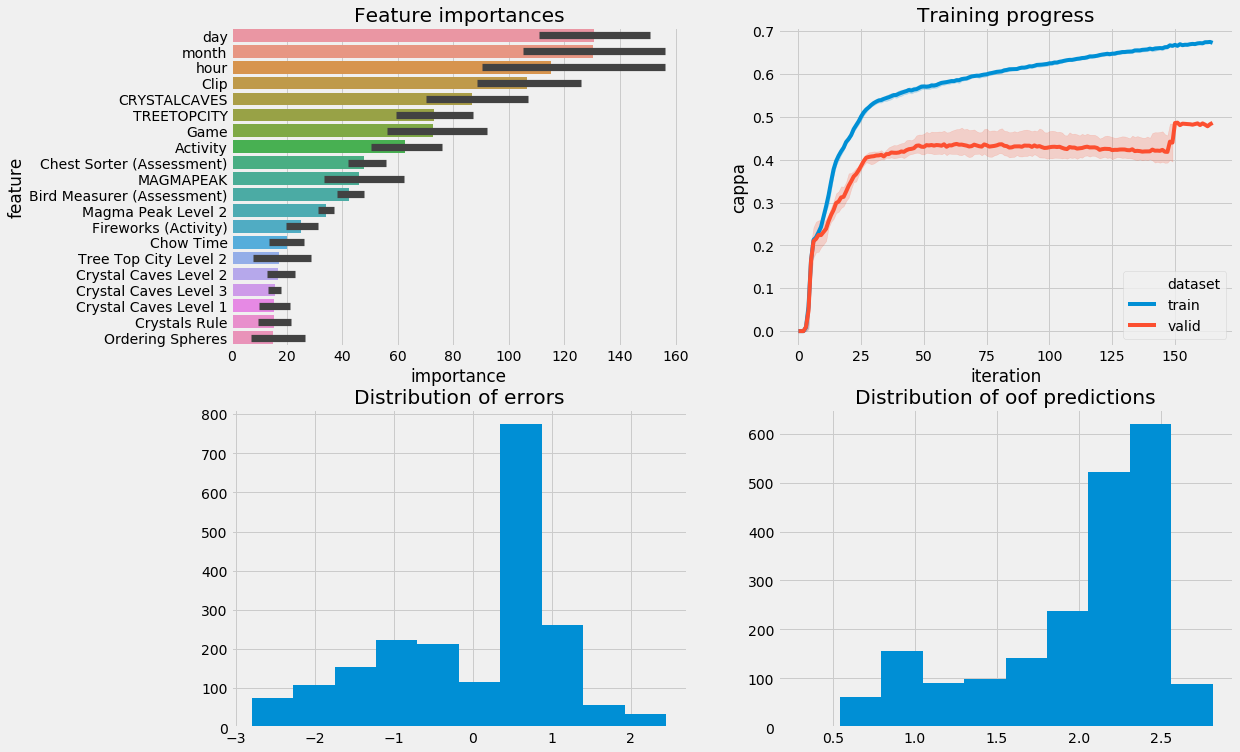

In [65]:
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X, y, folds=folds, params=params, transformers=transformers, eval_metric='cappa', cols_to_drop=cols_to_drop)

In [66]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [67]:
%%time
pr1 = regressor_model1.predict(X)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

CPU times: user 1.26 s, sys: 950 µs, total: 1.26 s
Wall time: 951 ms


In [68]:
coefficients

array([0.51517791, 1.71937199, 2.12367095])

In [69]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

0.5028499264310006

In [70]:
# using the optimized coefficients to round our test predictions
pr1 = regressor_model1.predict(final_fn)
pr1[pr1 <= coefficients[0]] = 0
pr1[np.where(np.logical_and(pr1 > coefficients[0], pr1 <= coefficients[1]))] = 1
pr1[np.where(np.logical_and(pr1 > coefficients[1], pr1 <= coefficients[2]))] = 2
pr1[pr1 > coefficients[2]] = 3

In [71]:
submit['accuracy_group'] = pr1.astype(int)
submit.to_csv('submission.csv', index=False)

In [72]:
submit['accuracy_group'].unique()

array([3, 1, 2])